In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import pickle
import scipy.stats as st
import itertools
import seaborn as sns

# Filters dataframe based on neuron type. 
# Establishes a synapse threshold of greater than 1
# data - the dataframe
# col_substr - regex to select for substrings that represent neuron type in columns
# row_substr - regex to select for substrings that represent neuron type in rows
# row_header - header for indices
def filter_neuron_types(data, col_substr, row_substr, idx_header):
    first_column = df.iloc[:, 0] # gets first column to use as row indices
    # columns
    new_df = data.filter(regex=col_substr, axis='columns') 
    
    # rows
    new_df.insert(0, idx_header, first_column, True) # inserts column with row labels into the new dataframe
    new_df.set_index(idx_header, inplace=True) # sets inserted column as dataframe indicies
    new_df = new_df.filter(regex=row_substr, axis='index')
    
    # establishing a threshold of num synapses > 1 to count as a connection
    num_rows = len(new_df)
    # loops thru rows of new_df
    for i in range(num_rows):
        row = new_df.iloc[i] # gets row
        new_row = np.where(row == 1, 0, row) # if synaspse num = 1, change to 0
        new_df.iloc[i] = new_row
    
    return new_df

# Normalizes weights by column's sum in a pandas df
# df - dataframe
# sum_of_w - the sum of the weights
def normalize_weights_df(df, sum_of_w):
    col = len(df.columns)
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = df.iloc[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            df.iloc[:,c] = [i/s for i in w]
    return sum_of_w * df

# Normalizes weights by column's sum in a numpy array
# arr - numpy array
# sum_of_w - the sum of the weights
def normalize_weights_np(arr, sum_of_w):
    col = len(arr[0])
    #df.iloc[:,0:col] = df.iloc[:,0:col].apply(lambda x: x / np.linalg.norm(x), axis=0)
    #df = normalize(df, axis=0, norm='l1') # normalize by column to sum of 1
    for c in range(col):
        w = arr[:,c]
        s = sum(abs(w)) # sum of column
        if (s != 0):
            arr[:,c] = [i/s for i in w]
    return sum_of_w * arr


df = pd.read_csv('connectivity matrix table 1.csv') # matrix of connections between neurons

# FILTER DATA FOR PNs (rows) to KCs (columns) CONNECTIONS -> pn_kc
pn_kc = filter_neuron_types(df, "(?=.*KC)(?=.*left)", "(?=.*PN)(?=.*left)", "Presynaptic PNs") # filter w/ regex PNs and KCs

# normalize weights
pn_kc = normalize_weights_df(pn_kc, 1)
#pn_kc = pn_kc.fillna(0)

# FILTER DATA FOR KCs TO MBONs CONNECTIONS -> kc_to_mbon
kc_mbon = filter_neuron_types(df, "(?=.*MBON)(?=.*left)", "(?=.*KC)(?=.*left)", "Presynaptic KCs") # filter w/ regex for KCs and MBON lefts

# take out MBONs with no KC connections
kc_mbon = kc_mbon.drop(kc_mbon.loc[:, (kc_mbon.sum(axis=0) == 0)], axis=1)

# adding a fictional MBON
fict_weights = np.full(len(kc_mbon), 0.1) # initializing all weights at 0.1
kc_mbon['MBON-fict'] = fict_weights

# normalizing weights
kc_mbon = normalize_weights_df(kc_mbon, 1)
kc_mbon = kc_mbon.fillna(0)

# Set numbers
num_kcs = len(pn_kc.columns)
num_pns = len(pn_kc) # number of PNs (40), also = number of dimensions of the odor
num_mbons = len(kc_mbon.columns)
R = 10 # number of realizations of training


# Intro

## 1. PN Activity Distribution

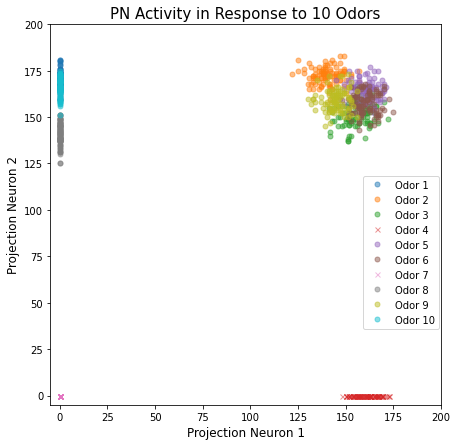

In [2]:
N = 10
num_pns = 40
num_inputs = 50000
spikes = 200

with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/input-means7.pkl', 'rb') as f:
    input_means = pickle.load(f)
    
response = input_means
# print(response)

bool_response = np.where(input_means > 0, 1, 0)
# print(bool_response)

all_inputs = np.zeros((num_inputs, num_pns))
odor_idx = num_inputs//N
pn_inputs = np.zeros((N, num_inputs//N, num_pns))
for n in range(N):
    inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
    all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
    pn_inputs[n] = inputs
    
# print("pn_inputs shape: {}".format(pn_inputs.shape))

# fire = np.ones((N, num_inputs//N))
# fire[2] = 0
# fire = fire.astype(int)
# print(fire)

# categories = ['x', 'o', 'o']
categories = ['o', 'o', 'o', 'x', 'o', 'o', 'x', 'o', 'o', 'o']
labels = []
for i in range(N):
    labels.append("Odor {}".format(i+1))

# plotting
plt.figure(figsize=(7,7))
for i in range(N):
    # 22, 23 - 10 odors
    # 9, 10 - 3 odors
    plt.plot(pn_inputs[i, 0:100, 22], pn_inputs[i, 0:100, 23], marker = categories[i], markersize=5, alpha = 0.5,
             label = labels[i], linestyle = '')
#     sns.scatterplot(x = pn_inputs[i, :, 9], y = pn_inputs[i, :, 10], s = 100, palette = 'Accent', style = categories[i])
plt.xlim(-5, 200)
plt.ylim(-5, 200)
plt.legend(loc=(0.8,0.2))
plt.title('PN Activity in Response to {} Odors'.format(N), fontsize=15)
plt.xlabel('Projection Neuron 1', fontsize=12)
plt.ylabel('Projection Neuron 2', fontsize=12)
plt.show()

### Histogram

(3, 40)
(3, 40)
[[0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0
  0 1 1 0]
 [1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1
  1 1 1 1]
 [0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0
  1 0 1 0]]
(3, 5000, 40)


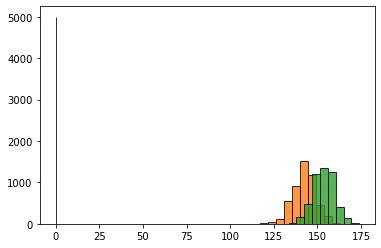

In [120]:
N = 3
num_pns = 40
num_inputs = 15000
spikes = 200

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control/input-means1.pkl', 'rb') as f:
    input_means = pickle.load(f)
    
response = input_means
print(response.shape)

bool_response = np.where(input_means > 0, 1, 0)
print(bool_response.shape)
print(bool_response)

all_inputs = np.zeros((num_inputs, num_pns))
odor_idx = num_inputs//N
pn_inputs = np.zeros((N, num_inputs//N, num_pns))
for n in range(N):
    inputs = np.random.binomial(spikes, response[n], size=(num_inputs//N, num_pns))
    all_inputs[n*odor_idx:odor_idx*(n + 1)] = inputs
    pn_inputs[n] = inputs
    
print(pn_inputs.shape)

# HISTOGRAM OF PN ACTIVITY
plt.figure()
plt.hist(pn_inputs[0, :, 9], alpha = 0.8, edgecolor='black')
plt.hist(pn_inputs[1, :, 9], alpha = 0.8, edgecolor='black')
plt.hist(pn_inputs[2, :, 9], alpha = 0.8, edgecolor='black')
plt.show()

## 2. Error Rates over Time

### Control

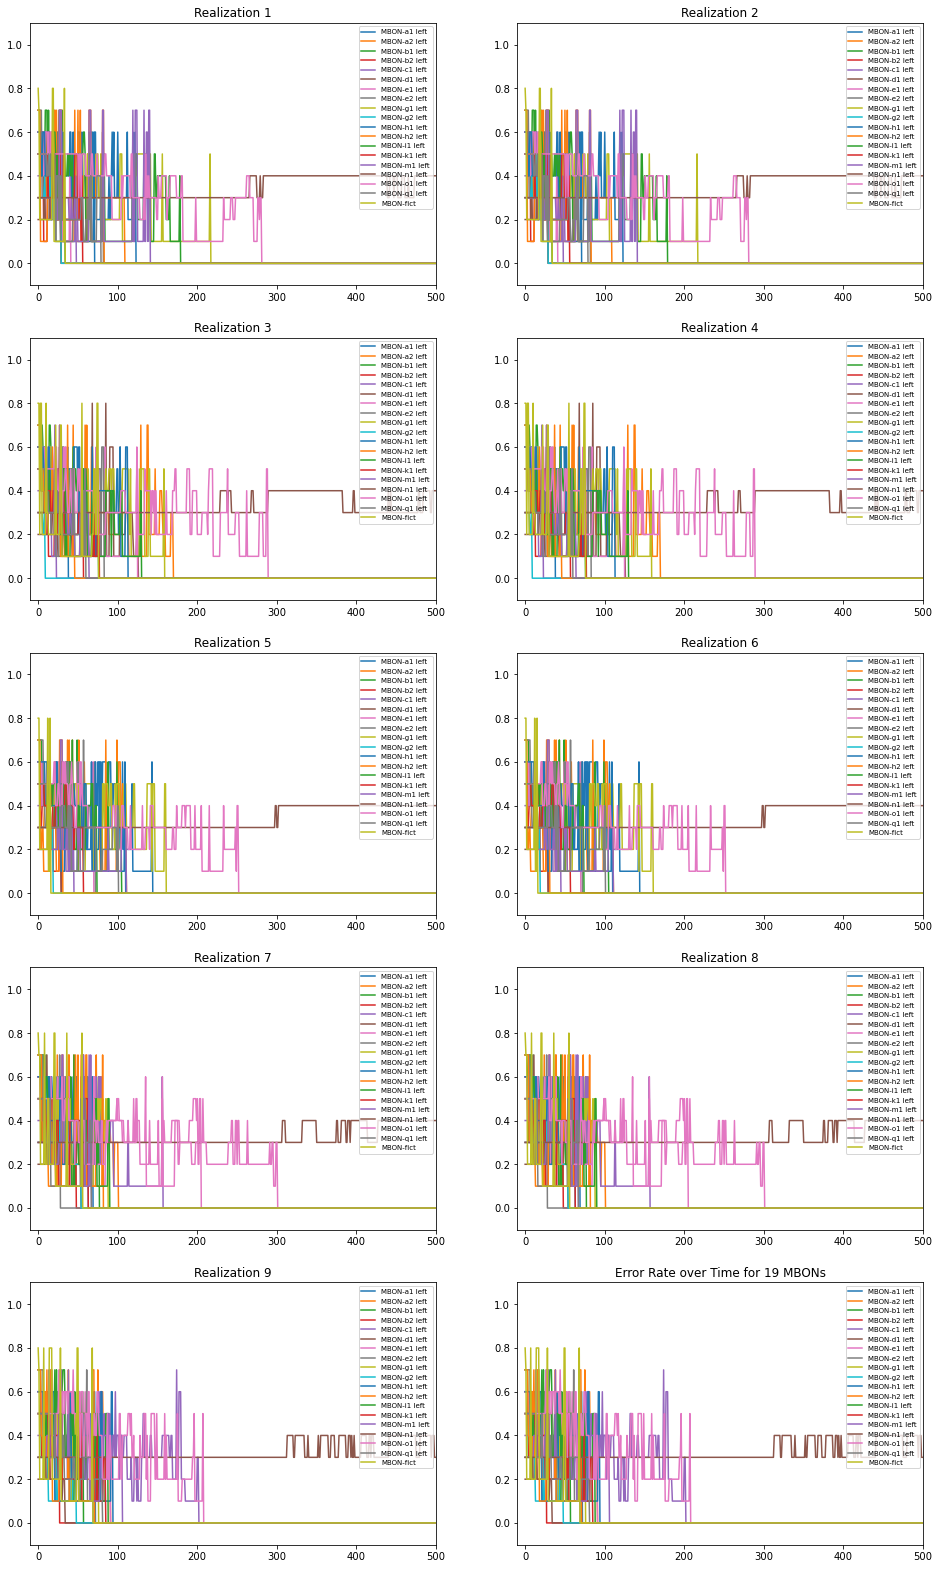

In [129]:
# PLOT ERROR RATES OVER TIME FOR ALL REALIZATIONS

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/control/all-error-rates4.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)
# print(error_rate_over_time.shape) 

figure, axis = plt.subplots(5, 2, figsize=(16, 28))

x = np.linspace(0, 5000, 5000)
a = 0
for r in range(5):
    for c in range(2):
        if a < 10:
            for i in range(num_mbons):
                axis[r, c].plot(x, error_rate_over_time[r, :, i], label = kc_mbon.columns[i])
                axis[r, c].legend(fontsize=7)
                axis[r, c].set_ylim(-0.1, 1.1)
                axis[r, c].set_xlim(-10, 500)
                axis[r, c].set_title("Realization {}".format(a+1))
            a += 1

plt.show()

#### Average Error Rate 

(10, 5000, 19)
(5000, 19)


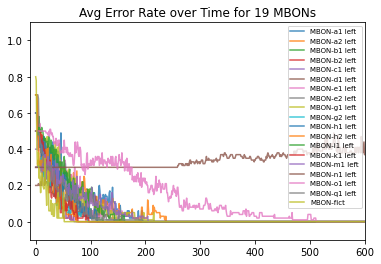

In [218]:
# PLOT AVERAGE ERROR RATES OVER TIME

with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/control2/all-error-rates7.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)
print(error_rate_over_time.shape) 

avg_error = np.mean(error_rate_over_time, axis=0)
print(avg_error.shape)

plt.figure()

x = np.linspace(0, 5000, 5000)
for i in range(num_mbons):
    plt.plot(x, avg_error[:,i], label = kc_mbon.columns[i], alpha=0.8)
    
plt.legend(fontsize=7)
plt.ylim(-0.1, 1.1)
plt.xlim(-10, 600)
plt.title("Avg Error Rate over Time for 19 MBONs")

plt.show()

## Weights over Time

### Control

#### 10 Odors

(3, 1, 200, 110, 19)


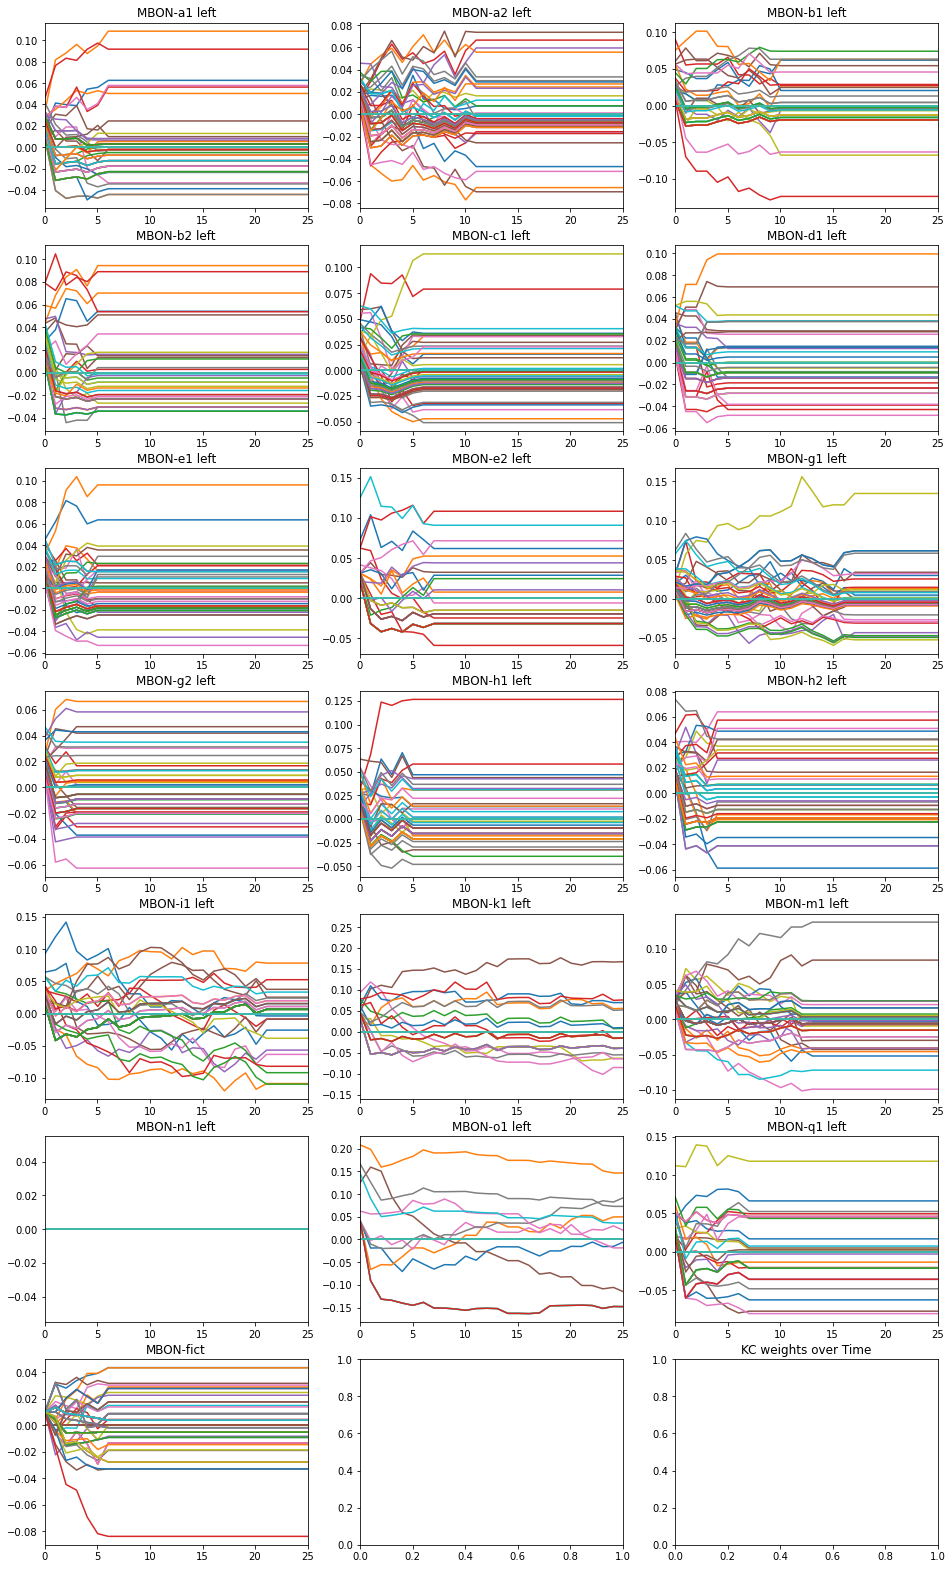

In [22]:
# PLOT WEIGHTS OVER TIME
with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-ablation2/total-weights10.pkl', 'rb') as f:
    weights_over_time = pickle.load(f)
print(weights_over_time.shape) 

figure, axis = plt.subplots(7, 3, figsize=(16, 28))
x = np.linspace(0, 200, 200)

m = 0
for r in range(7):
    for c in range(3):
        if m < 19:
            for k in range(num_kcs):
                axis[r, c].plot(x, weights_over_time[2, 0, :, k, m])
            axis[r, c].set_title(kc_mbon.columns[m])
            axis[r, c].set_xlim(0, 25)
#             axis[r, c].set_ylim(-0.1, 0.5)
            m += 1
plt.title("KC weights over Time")
plt.show()

## Biases over Time

(10, 5000, 19)


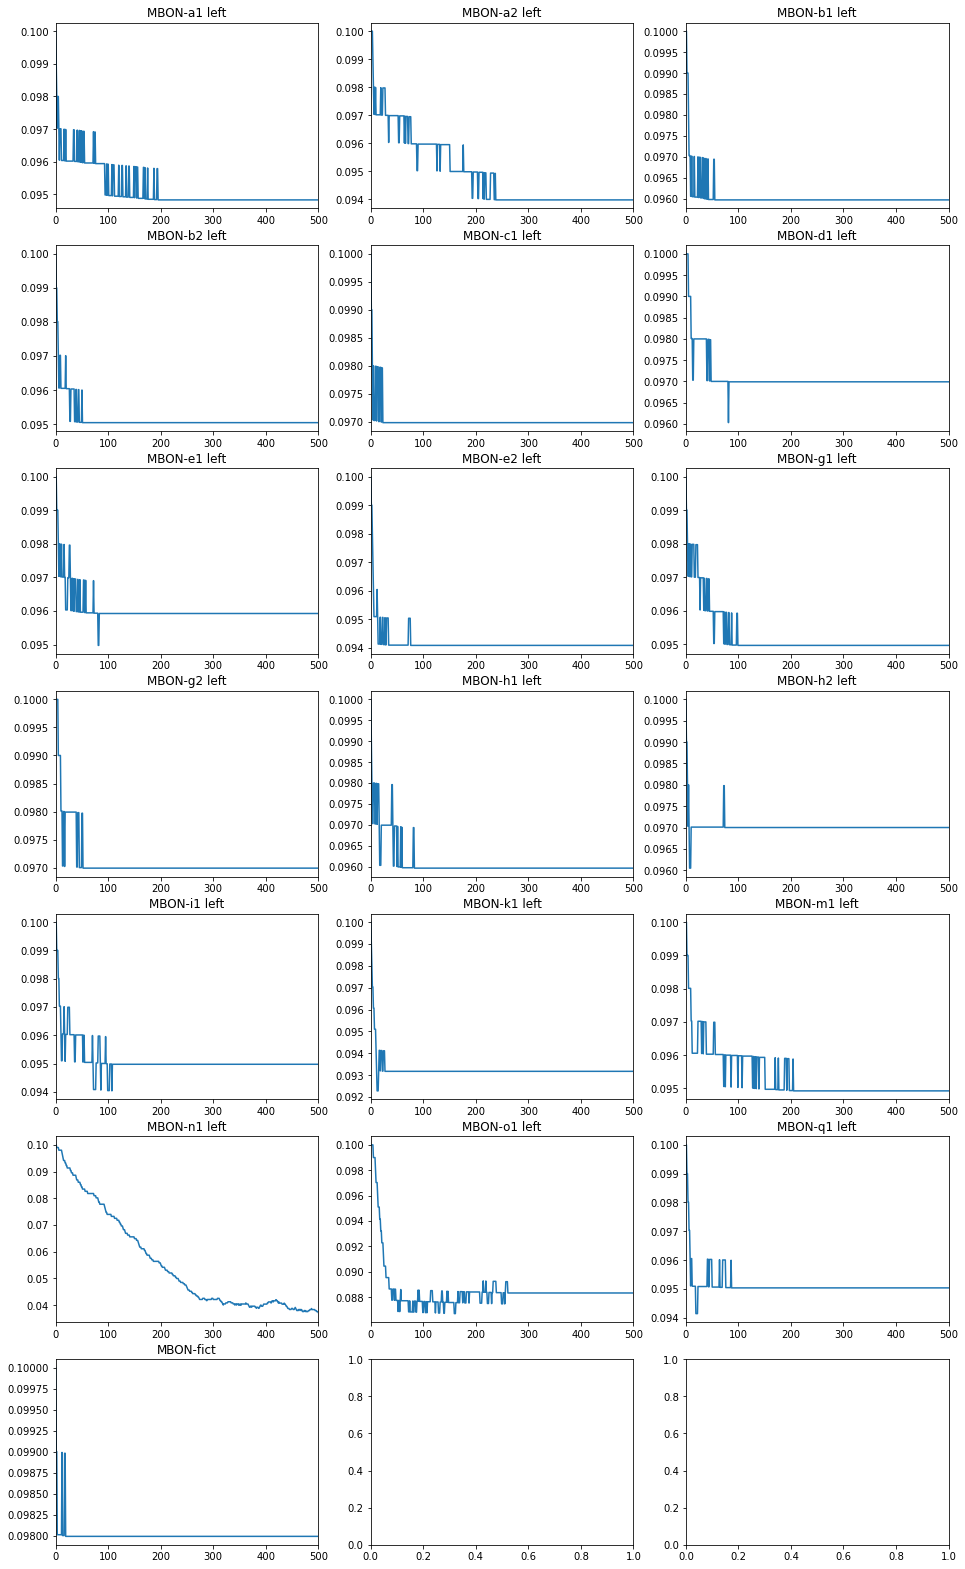

In [212]:
# PLOT BIASES OVER TIME
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/control2/total-biases7.pkl', 'rb') as f:
    bias_over_time = pickle.load(f)
print(bias_over_time.shape) 

figure, axis = plt.subplots(7, 3, figsize=(16, 28))
x = np.linspace(0, 5000, 5000)

m = 0
for r in range(7):
    for c in range(3):
        if m < 19:
            axis[r, c].plot(x, bias_over_time[0, :, m])
            axis[r, c].set_title(kc_mbon.columns[m])
            axis[r, c].set_xlim(0, 500)
#             axis[r, c].set_ylim(-0.1, 0.5)
            m += 1
# plt.title("KC weights over Time")
plt.show()

# Results

## Distributions of KC Weights Before and After Training

(10, 5000, 110, 19)


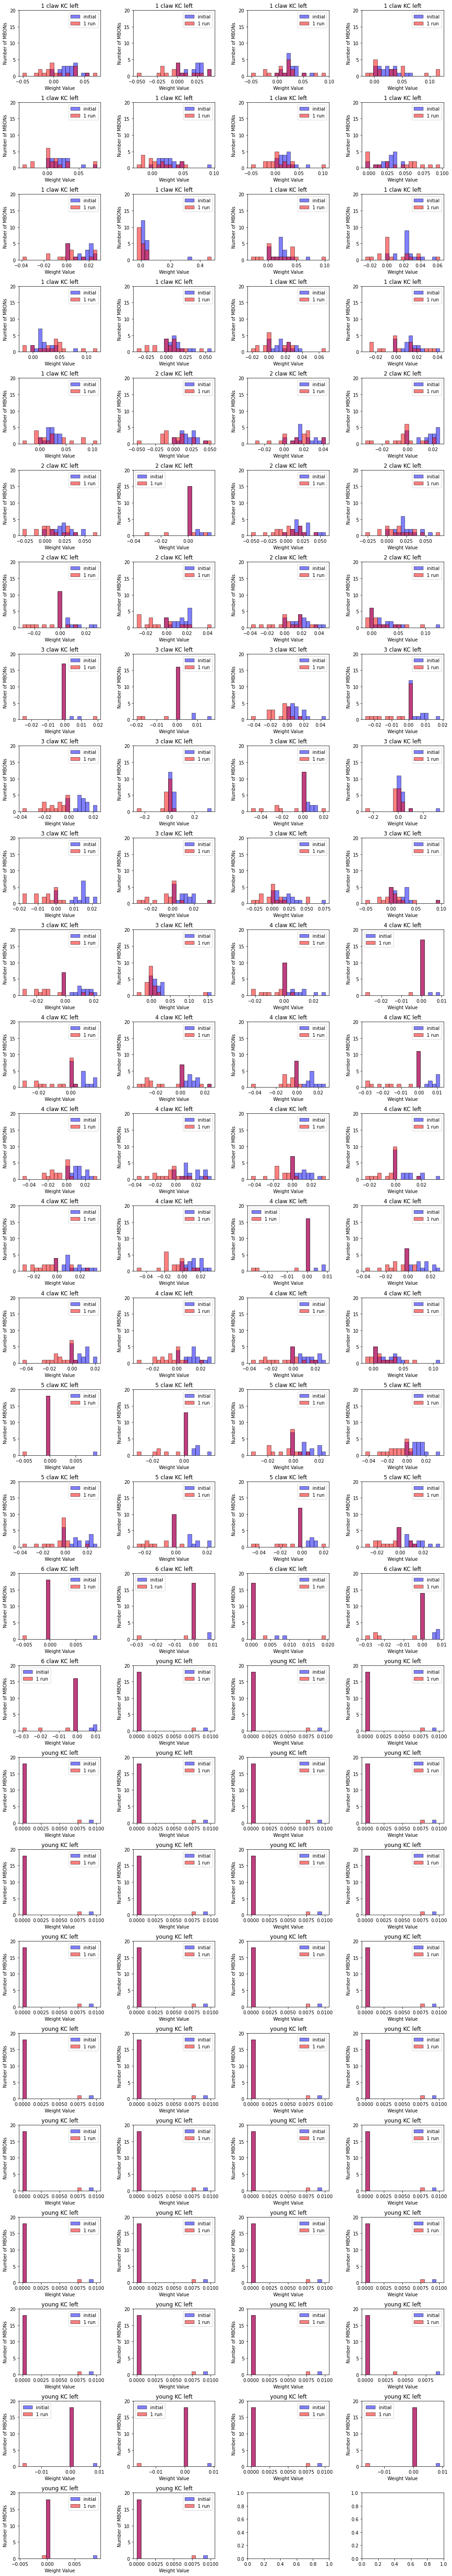

In [4]:
# HISTOGRAM OF KC'S TOTAL OUTPUT SYNAPTIC WEIGHT BEFORE VS AFTER TRAINING
with open('C:/Katherine/Research/experiment-data-v3/10-odors-control/total-weights7.pkl', 'rb') as f:
    weights_over_time = pickle.load(f)
print(weights_over_time.shape) 
    
# average final weights over 10
avg_weights = np.mean(weights_over_time, axis=0)

# HISTOGRAM OF THE DISTRIBUTION OF TOTAL KC WEIGHTS (BEFORE & AFTER TRAINING) 
figure, axis = plt.subplots(28, 4, figsize=(16,64))

k = 0
for i in range(28):
    for j in range(4):
        if k < 110:
            
            x = np.zeros((3, num_mbons))
            x[0] = kc_mbon.iloc[k]
            x[1] = weights_over_time[0, -1, k] # final weights after realization #1 of training
            x[2] = avg_weights[-1, k]

            # initial weights
            axis[i, j].hist(x[0], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='blue', alpha=0.5, label='initial')

            # final weights after 1 training run
            axis[i, j].hist(x[1], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='red', alpha=0.5, label='1 run')

            # final weights avgeraged over 10 training runs
#             axis[i, j].hist(x[2], bins=np.linspace(x.min(), x.max(), 20), edgecolor='black', color='green', alpha=0.5, label='avg over 10')

            axis[i, j].set_title(kc_mbon.index[k])
            axis[i, j].set_xlabel('Weight Value')
            axis[i, j].set_ylabel('Number of MBONs')
            axis[i, j].set_ylim(0, 20)
            axis[i, j].legend()
        
        k += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)


plt.show()

## Scatter Plot of Mean vs STD of Change in Weights (After - Before)

### Control - Each Realization

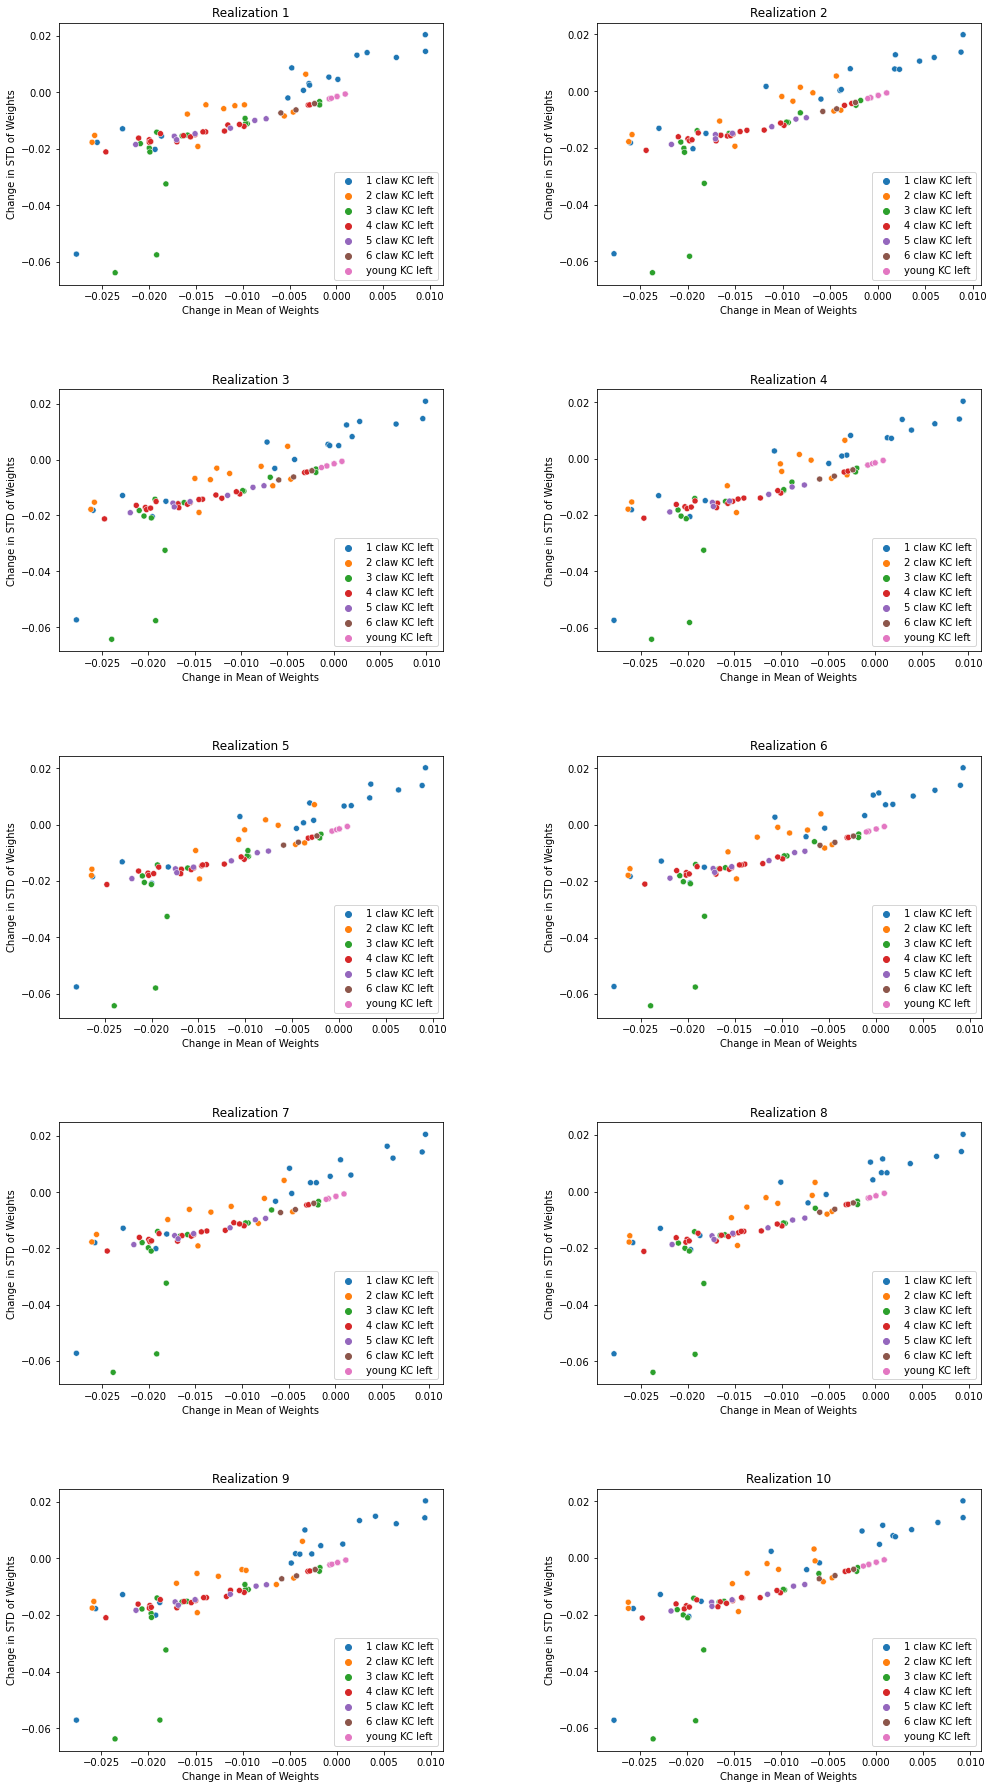

In [170]:
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/total-weights7.pkl', 'rb') as f:
    weights_over_time = pickle.load(f)
# print(weights_over_time.shape)

mean_weights = np.mean(weights_over_time, axis = 3)
std_weights = np.mean(weights_over_time, axis = 3)
# print(std_weights.shape)

init_mean_weights = np.mean(kc_mbon, axis = 1)
init_std_weights = np.std(kc_mbon, axis = 1)

# plot scatter plots of std vs mean
figure, axis = plt.subplots(5, 2, figsize=(16,20))

r = 0 # realization number
for i in range(5):
    for j in range(2):
        # x axis - difference in means of KC weights
        x = mean_weights[r, -1] - init_mean_weights

        # y axis - difference in stds of KC weights
        y = std_weights[r, -1] - init_std_weights

        # create dataframe to organize scatter plot values
        names = kc_mbon.index
        # print(names.shape)
        df = pd.DataFrame({'Type of KC':names, 'Mean':x, 'STD':y})

        # attribute colors to each type of KC
        # colors = {'1 claw KC left':'blue', '2 claw KC left':'orange', '3 claw KC left':'green', '4 claw KC left':'red',
        #          '5 claw KC left':'purple', '6 claw KC left':'brown', 'young KC left':'pink'}
        
        # scatter plot
        sns.scatterplot(ax=axis[i, j], x=df['Mean'], y=df['STD'], hue=df['Type of KC'])
        axis[i, j].set_xlabel('Change in Mean of Weights')
        axis[i, j].set_ylabel('Change in STD of Weights')
        axis[i, j].legend(loc=4)
        axis[i, j].set_title('Realization {}'.format(r+1))
        r += 1


# axis[0, 0].scatter(df['Mean'], df['STD'], c=df['Type of KC'].map(colors), label=df['Type of KC'])
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.3, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

### Control - Average across Realizations

(10, 5000, 110, 19)
(10, 5000, 110)
(10, 110)
(110,)


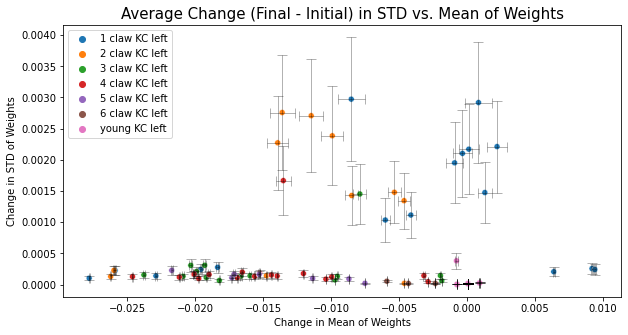

In [223]:
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control2/total-weights7.pkl', 'rb') as f:
    weights_over_time = pickle.load(f)
print(weights_over_time.shape)

mean_weights = np.mean(weights_over_time, axis = 3)
std_weights = np.mean(weights_over_time, axis = 3)
print(std_weights.shape)

# organize into dataframe 
# x axis - difference in means of final and initial KC weights
x = mean_weights[:, -1] - mean_weights[:, 0]

# y axis - difference in stds of final and initial KC weights
y = std_weights[:, -1] - std_weights[:, 0]
print(y.shape)

# average mean and std across realizations
avg_of_mean_weights = np.mean(x, axis = 0)
avg_of_std_weights = np.std(y, axis = 0)
print(avg_of_std_weights.shape)

# create dataframe to organize scatter plot values
names = kc_mbon.index
# print(names.shape)
df = pd.DataFrame({'Type of KC':names, 'Mean':avg_of_mean_weights, 'STD':avg_of_std_weights})

colors = {'1 claw KC left':'blue', '2 claw KC left':'orange', '3 claw KC left':'green', '4 claw KC left':'red',
          '5 claw KC left':'purple', '6 claw KC left':'brown', 'young KC left':'pink'}

# get sem
sem_m = st.sem(x, axis=0)
sem_s = st.sem(y, axis=0)

# plot scatter plots of std vs mean
plt.figure(figsize=(10,5))
plt.errorbar(x=df['Mean'], y=df['STD'], xerr=sem_m, yerr=sem_s, capsize=5, color='black', alpha=0.3,
             linewidth=1, linestyle='', marker=None)
sns.scatterplot(x=df['Mean'], y=df['STD'], hue=df['Type of KC'])

# sns.pointplot(x=df['Mean'], y=df['STD'], hue=df['Type of KC'], data=df, join=False)
plt.xlabel('Change in Mean of Weights')
plt.ylabel('Change in STD of Weights')
plt.legend(loc=2)
plt.title('Average Change (Final - Initial) in STD vs. Mean of Weights', fontsize=15)
plt.show()

### Error Rates over Time

#### All Realizations (for one number of KCs removed)

(23, 10, 5000, 19)


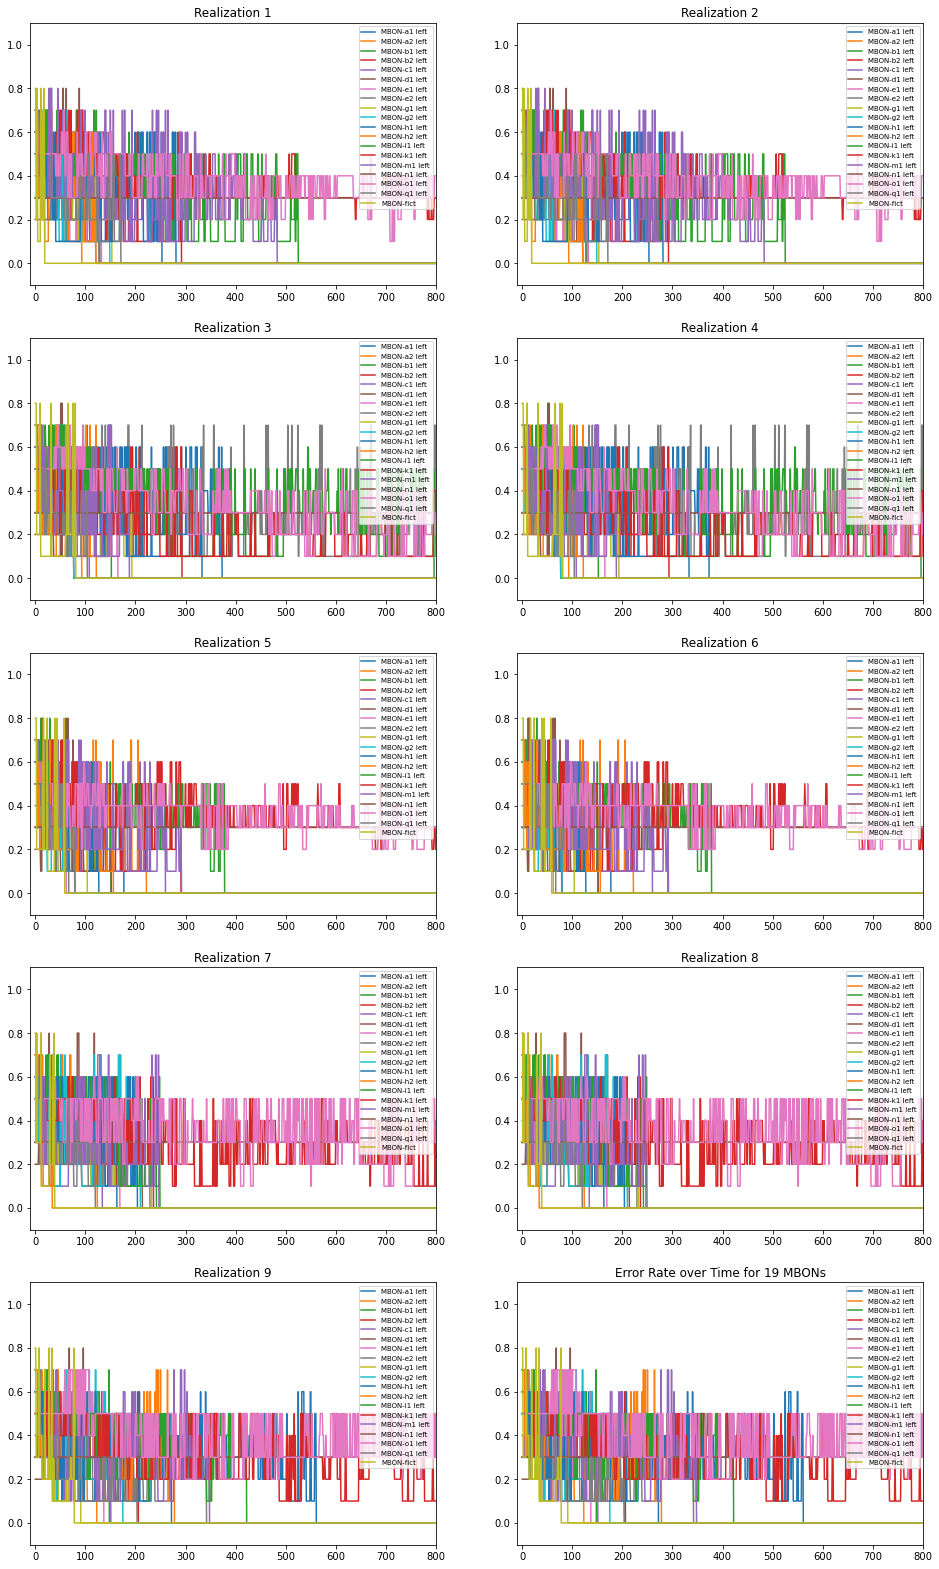

In [7]:
# PLOT ERROR RATES OVER TIME FOR ALL REALIZATIONS (EXPERIMENT)

with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-ablation/all-error-rates5.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)
print(error_rate_over_time.shape) 

idx_removed = 3
figure, axis = plt.subplots(5, 2, figsize=(16, 28))

x = np.linspace(0, 5000, 5000)
a = 0
for r in range(5):
    for c in range(2):
        if a < 10:
            for i in range(num_mbons):
                axis[r, c].plot(x, error_rate_over_time[idx_removed, r, :, i], label = kc_mbon.columns[i])
                axis[r, c].legend(fontsize=7)
                axis[r, c].set_ylim(-0.1, 1.1)
                axis[r, c].set_xlim(-10, 800)
                axis[r, c].set_title("Realization {}".format(a+1))
            a += 1

plt.title("Error Rate over Time for 19 MBONs")
plt.show()

#### Average Error Rate (for all numbers of KCs removed)

(23, 10, 5000, 19)
(23, 5000, 19)


<Figure size 432x288 with 0 Axes>

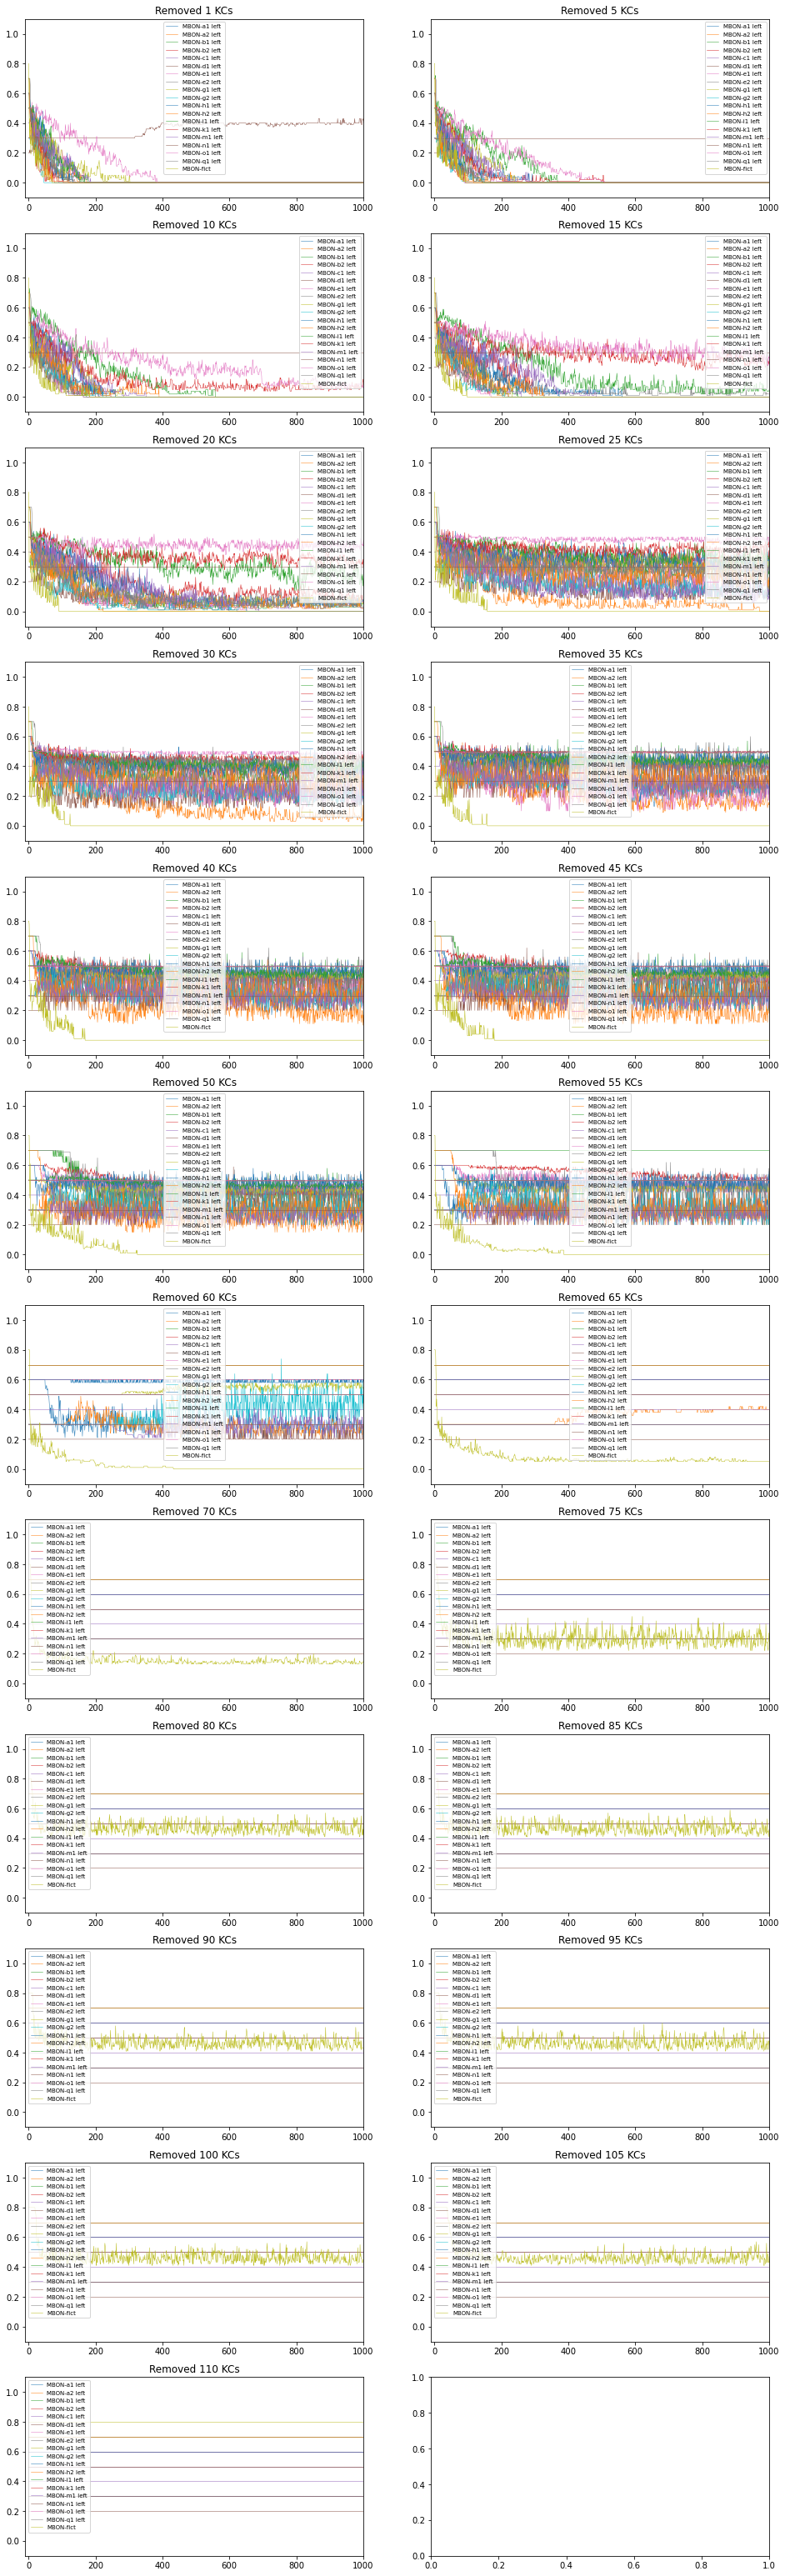

In [8]:
# PLOT AVERAGE ERROR RATES OVER TIME

# list of num of KCs removed
num_removed = np.ones(23)
num_removed[1:] = np.linspace(5, 110, 22)
num_removed = num_removed.astype(int)

with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-ablation/all-error-rates5.pkl', 'rb') as f:
    error_rate_over_time = pickle.load(f)
print(error_rate_over_time.shape) 

avg_error = np.mean(error_rate_over_time, axis=1)
print(avg_error.shape)

plt.figure()
figure, axis = plt.subplots(12, 2, figsize=(16, 56))
x = np.linspace(0, 5000, 5000)

k = 0
for r in range(12):
    for c in range(2):
        if k < 23:
            for i in range(num_mbons):
                axis[r, c].plot(x, avg_error[k, : ,i], label = kc_mbon.columns[i], linewidth = 0.5)
                axis[r, c].set_ylim(-0.1, 1.1)
                axis[r, c].set_xlim(-10, 1000)
                axis[r, c].legend(fontsize=7)
                axis[r, c].set_title("Removed {} KCs".format(num_removed[k]))
            k += 1

plt.show()

## Final Avg. Error Rate vs. KCs Removed

### Targeted Ablation

#### 3 Odors

(23, 10, 5000, 19)


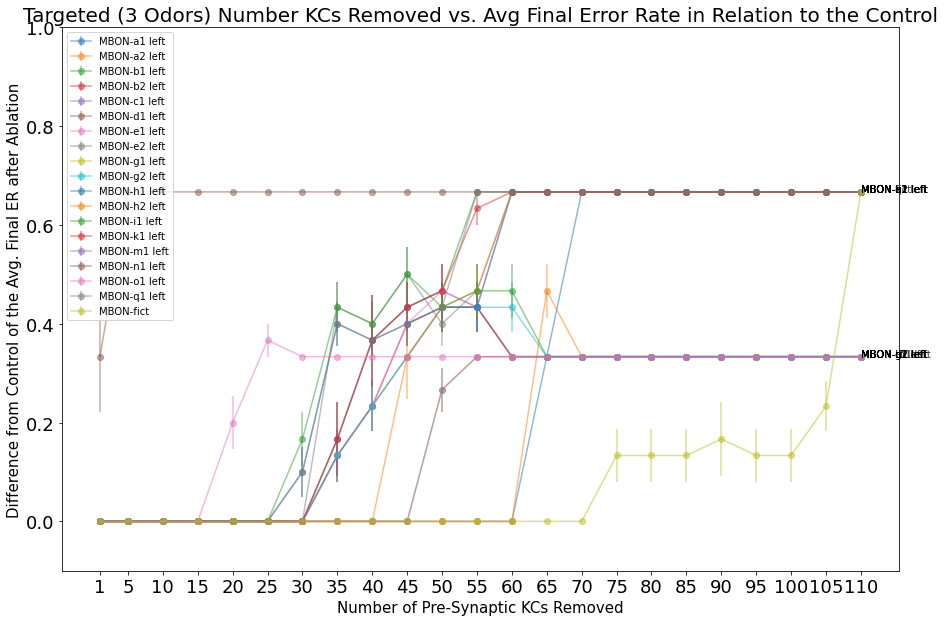

In [12]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - TARGETED ABLATION OF TOP KCS
num_mbons = 19
K = 23
T = 5000

# import data
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/targeted-ablation/all-error-rates2.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/3-odors/control/all-error-rates1.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

print(error_over_time.shape)
plt.figure(figsize=(15, 10))
# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 
x = []
        
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(error_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(error_over_time[i], axis=0)
    std_y[i] = st.sem(error_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
#     plt.scatter(x[start:end], y[start:end], alpha=0.3)
#     plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], alpha=0.8)
    plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, label=kc_mbon.columns[p])
    plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=15)
plt.ylabel("Difference from Control of the Avg. Final ER after Ablation", fontsize=15)
plt.xticks(numbers, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1, 1.0)
plt.title("Targeted (3 Odors) Number KCs Removed vs. Avg Final Error Rate in Relation to the Control", fontsize=20)
plt.legend()
plt.show()

#### 10 Odors

(23, 10, 5000, 19)


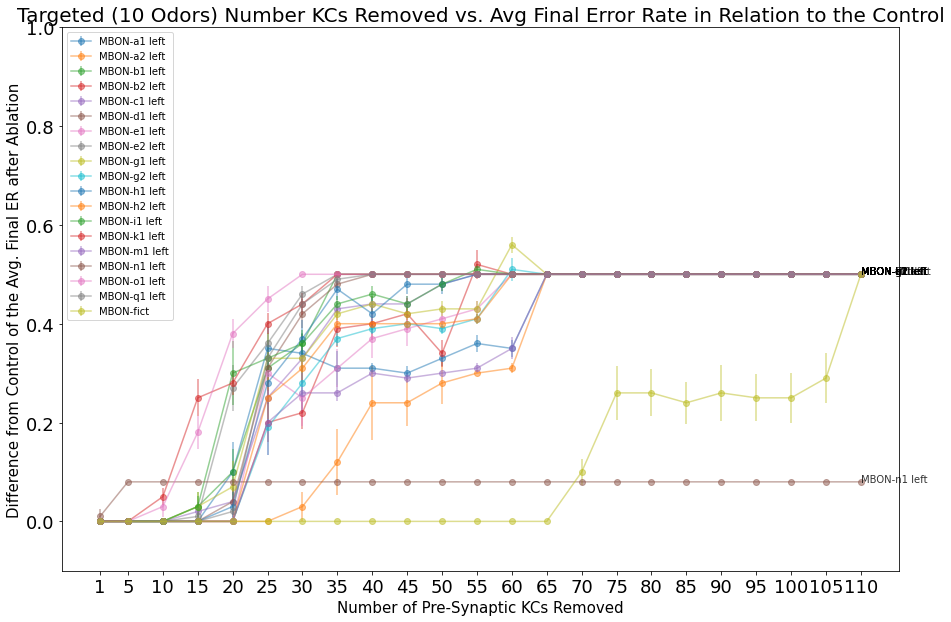

In [3]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - TARGETED ABLATION OF TOP KCS
num_mbons = 19
K = 23
T = 5000

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-ablation/all-error-rates10.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/all-error-rates7.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

print(error_over_time.shape)
plt.figure(figsize=(15, 10))
# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 
x = []
        
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(error_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
for i in range(K):
#     std_y[i] = np.std(error_over_time[i], axis=0)
    std_y[i] = st.sem(error_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
#     plt.scatter(x[start:end], y[start:end], alpha=0.3)
#     plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], alpha=0.8)
    plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, label=kc_mbon.columns[p])
    plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=15)
plt.ylabel("Difference from Control of the Avg. Final ER after Ablation", fontsize=15)
plt.xticks(numbers, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1, 1.0)
plt.title("Targeted (10 Odors) Number KCs Removed vs. Avg Final Error Rate in Relation to the Control", fontsize=20)
plt.legend()
plt.show()

### Random Ablation

#### 3 Odors

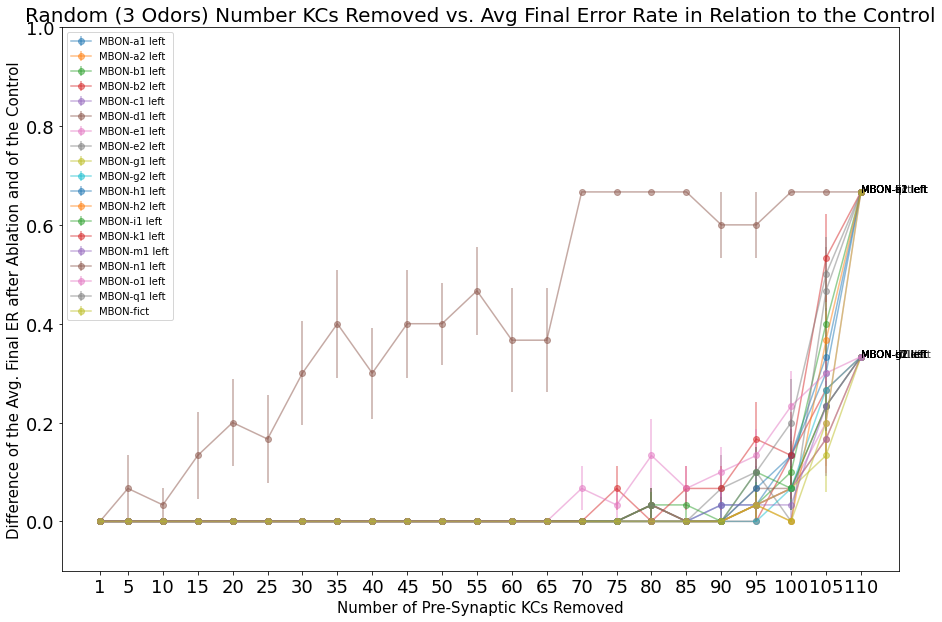

In [13]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - RANDOM ABLATION

# import data
     
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/random-ablation/all-error-rates3.pkl', 'rb') as f:
    error_over_time = pickle.load(f)
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control/all-error-rates1.pkl', 'rb') as f:
    error_control = pickle.load(f)
    
plt.figure(figsize=(15, 10))
# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 
x = []
        
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(error_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
# print(error_over_time[0, :, -1, :].shape)
for i in range(K):
#     std_y[i] = np.std(error_over_time[i], axis=0)
    std_y[i] = st.sem(error_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
#     plt.scatter(x[start:end], y[start:end], alpha=0.3)
#     plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], alpha=0.8)
    plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, label=kc_mbon.columns[p])
    plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))

plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=15)
plt.ylabel("Difference of the Avg. Final ER after Ablation and of the Control", fontsize=15)
plt.title("Random (3 Odors) Number KCs Removed vs. Avg Final Error Rate in Relation to the Control", fontsize=20)
plt.xticks(numbers, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1, 1.0)
plt.legend()
plt.show()

#### 10 Odors

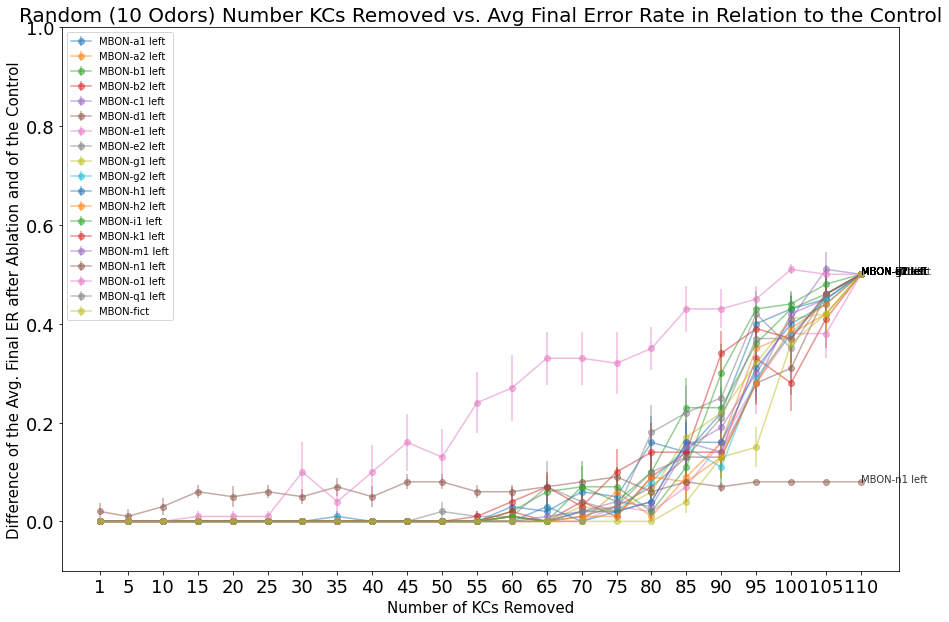

In [7]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - RANDOM ABLATION

# import data
     
with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-ablation/all-error-rates11.pkl', 'rb') as f:
    error_over_time = pickle.load(f)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/all-error-rates7.pkl', 'rb') as f:
    error_control = pickle.load(f)
    
K = 23
T = 5000
    
plt.figure(figsize=(15, 10))
# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 
x = []
        
for i in range(num_mbons):
    for j in range(K):
        x.append(numbers[j])

# y-axis - avg final error rate
avg_error0 = np.mean(error_control, axis=0)
avg_error = np.zeros((K, T, num_mbons))
for i in range(K):
    avg_error[i] = np.mean(error_over_time[i], axis=0)

std_y = np.zeros((K, T, num_mbons))
# print(error_over_time[0, :, -1, :].shape)
for i in range(K):
#     std_y[i] = np.std(error_over_time[i], axis=0)
    std_y[i] = st.sem(error_over_time[i], axis=0)

yerr = []
for k in range(num_mbons):
    for i in range(K):
        yerr.append(std_y[i,-1,k])
    
y = []
# add differences in ablation error rate and control
for k in range(num_mbons):
    for i in range(K):
        y.append(avg_error[i,-1,k] - avg_error0[-1,k])

# plot points with lines and labels
names = kc_mbon.columns
for p in range(num_mbons):
    start = p * K
    end = (p * K) + K
#     plt.scatter(x[start:end], y[start:end], alpha=0.3)
#     plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], alpha=0.8)
    plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, label=kc_mbon.columns[p])
    plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))

plt.xlabel("Number of KCs Removed", fontsize=15)
plt.ylabel("Difference of the Avg. Final ER after Ablation and of the Control", fontsize=15)
plt.title("Random (10 Odors) Number KCs Removed vs. Avg Final Error Rate in Relation to the Control", fontsize=20)
plt.xticks(numbers, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1, 1.0)
plt.legend()
plt.show()

## Final Avg Error Rate vs # of Synapses Removed
### Targeted

23 10 1
['3 claw KC left 33']
number of presynaptic KCs:
[ 55  63  46  47  54  53  59  38  61  61  54  53  42  30  51   3  17  36
 110]


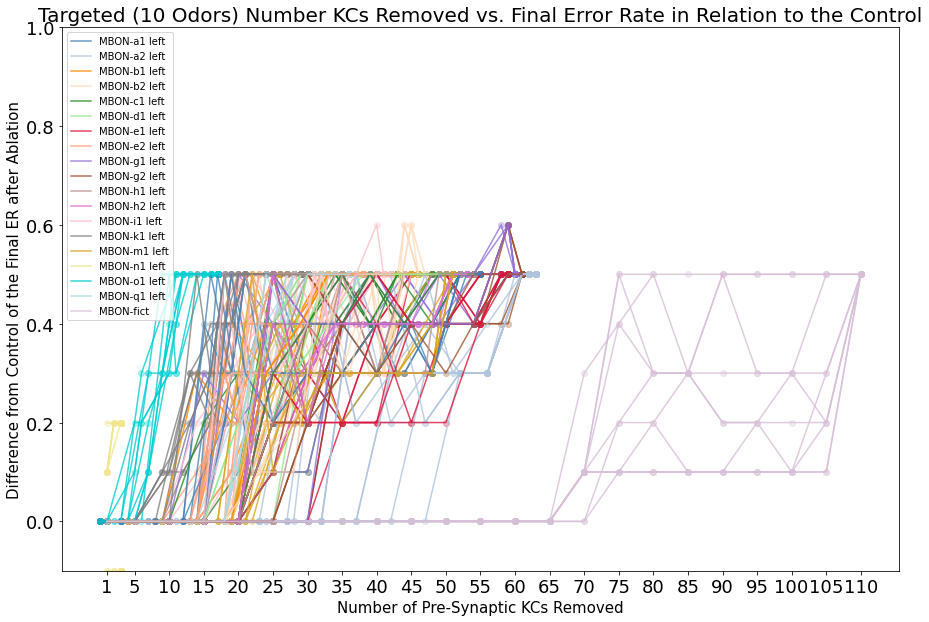

In [14]:
# NUMBER OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - TARGETED ABLATION OF TOP KCS (1 realization)
num_mbons = 19
K = 23
T = 5000

# get the number kc from string arr
# a - num kcs removed
def get_num_kc(str, a):
#     print("a", a)
    nums = np.zeros(a)
    for i in range(a):
        end = False
        s = str[i]
        j = 1
        num_str = ""
        while end == False:
#             print("s",s)
#             print("s[-j]",s[-j])
#             print("j",j)
            # end loop if space is reached
            if s[-j] == " ": 
                end = True
#                 print(end)
            else:
                num_str = s[-j] + num_str
            j += 1
        nums[i] = int(num_str)
    return nums

# mbon - index of mbon
def count_num_removed(kc_mbon, nums, mbon):
    count = 0
    nums = nums.astype(int)
    for i in range(len(nums)):
#         print(nums[i])
#         print("there?:", kc_mbon.iloc[nums[i], mbon] != 0)
        if kc_mbon.iloc[nums[i], mbon] != 0:
            count += 1
    return count
    

# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-ablation/all-error-rates10.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/targeted-ablation/kcs-removed10.pkl', 'rb') as f:
    kcs_removed = pickle.load(f)
print(len(kcs_removed), len(kcs_removed[0]), len(kcs_removed[0][0]))
print(kcs_removed[0][0])
# print(kcs_removed)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/all-error-rates7.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

# print(error_over_time.shape) # 23, 10, 5000, 19
plt.figure(figsize=(15, 10))

# 19 colors - one for each MBON
colors = ['steelblue', 'lightsteelblue', 'darkorange', 'peachpuff', 'forestgreen', 
          'lightgreen', 'crimson', 'lightsalmon', 'mediumpurple', 'sienna', 'rosybrown', 
          'orchid', 'pink', 'gray', 'goldenrod', 'khaki', 'darkturquoise', 'lightblue', 
          'thistle']

# gets number of presynaptic KCs for each MBON
bool_synapses = np.where(kc_mbon > 0, 1, 0)
print("number of presynaptic KCs:")
conn = np.zeros(num_mbons)
for j in range(num_mbons):
    conn[j] = bool_synapses[:,j].sum()
conn = conn.astype(int)
print(conn)
    
# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 

for r in range(R):
    x = []

    # x-axis calculations 
    for i in range(num_mbons):
        for j in range(K):
            n = numbers[j] # num kcs ablated
            l = kcs_removed[j][r] # list of kcs removed for realization 1
            l_num = get_num_kc(l, n) # converts list of names to numbers

            num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON
            x.append(num_removed)    

    # print(x)

    # y-axis - final error rate for realization r
    y = []
    # print(error_over_time.shape)
    # print(error_control.shape)
    for m in range(num_mbons):
        for k in range(K):
            y.append(error_over_time[k, r, -1, m] - error_control[r, -1, m]) # r = realization

    # plot points with lines and labels
    names = kc_mbon.columns
    for p in range(num_mbons):
        start = p * K
        end = (p * K) + K
        plt.scatter(x[start:end], y[start:end], alpha=0.3, c=colors[p])
        plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], color=colors[p], alpha=0.8)
    #     plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, label=kc_mbon.columns[p])
    #     plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))
    if r == 0:
        plt.legend()
plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=15)
plt.ylabel("Difference from Control of the Final ER after Ablation", fontsize=15)
plt.xticks(numbers, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.1, 1.0)
plt.title("Targeted (10 Odors) Number KCs Removed vs. Final Error Rate in Relation to the Control", fontsize=20)
plt.show()

number of presynaptic KCs:
[ 55  63  46  47  54  53  59  38  61  61  54  53  42  30  51   3  17  36
 110]


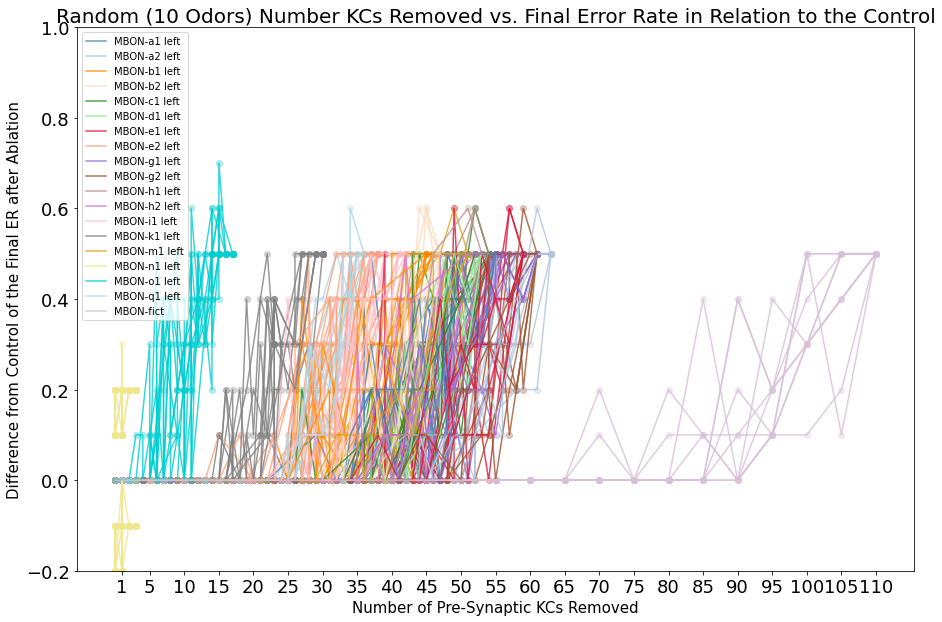

In [18]:
# import data
with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-ablation2/all-error-rates14.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/random-ablation2/kcs-removed14.pkl', 'rb') as f:
    kcs_removed = pickle.load(f)
    
with open('C:/Katherine/Research/experiment-data-v3/10-odors/control2/all-error-rates7.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

# print(error_over_time.shape) # 23, 10, 5000, 19
plt.figure(figsize=(15, 10))

# 19 colors - one for each MBON
colors = ['steelblue', 'lightsteelblue', 'darkorange', 'peachpuff', 'forestgreen', 
          'lightgreen', 'crimson', 'lightsalmon', 'mediumpurple', 'sienna', 'rosybrown', 
          'orchid', 'pink', 'gray', 'goldenrod', 'khaki', 'darkturquoise', 'lightblue', 
          'thistle']

# gets number of presynaptic KCs for each MBON
bool_synapses = np.where(kc_mbon > 0, 1, 0)
print("number of presynaptic KCs:")
conn = np.zeros(num_mbons)
for j in range(num_mbons):
    conn[j] = bool_synapses[:,j].sum()
conn = conn.astype(int)
print(conn)
    
# x-axis -> number of KCs removed
numbers = np.ones(23)
numbers[1:] = np.linspace(5, 110, 22)
numbers = numbers.astype(int).tolist() 

for r in range(R):
    x = []

    # x-axis calculations 
    for i in range(num_mbons):
        for j in range(K):
            n = numbers[j] # num kcs ablated
            l = kcs_removed[j][r] # list of kcs removed for realization r
            l_num = get_num_kc(l, n) # converts list of names to numbers

            num_removed = count_num_removed(kc_mbon, l_num, i) # number of kc connections removed from this MBON

            x.append(num_removed)    

    # print(x)

    # y-axis - final error rate for realization #1
    y = []
    for m in range(num_mbons):
        for k in range(K):
            y.append(error_over_time[k, r, -1, m] - error_control[r, -1, m]) # r = realization
    # print(y)
    # plot points with lines and labels
    names = kc_mbon.columns
    for p in range(num_mbons):
        start = p * K
        end = (p * K) + K
        
        # sort x values
        i_x = np.argsort(x[start:end])
        temp_x = np.array(x[start:end])
        temp_y = np.array(y[start:end])
        x_s = temp_x[i_x]
        y_s = temp_y[i_x]
        
        plt.scatter(x_s, y_s, alpha=0.3, c=colors[p])
        plt.plot(x_s, y_s, label=kc_mbon.columns[p], color=colors[p], alpha=0.8)
    #     plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, label=kc_mbon.columns[p])
    #     plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))
    if r == 0:
        plt.legend()
plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=15)
plt.ylabel("Difference from Control of the Final ER after Ablation", fontsize=15)
plt.xticks(numbers, fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(-0.2, 1.0)
plt.title("Random (10 Odors) Number KCs Removed vs. Final Error Rate in Relation to the Control", fontsize=20)
plt.show()

## Final Avg Error Rate vs % KCs Removed

In [138]:
# plot the kcs final avg
def plot_error_vs_percentKCsRemoved(kc_mbon, error_control, error_over_time):
    num_mbons = 19
    K = 23
    T = 5000
    plt.figure(figsize=(16, 8))
    # x-axis -> number of KCs removed
    numbers = np.ones(23)
    numbers[1:] = np.linspace(5, 110, 22)
    numbers = numbers.astype(int).tolist() 

    bool_conn = np.where(kc_mbon > 0, 1, 0)
    num_conn = np.zeros(num_mbons) # number of connections from presynaptic KCs
    for j in range(num_mbons):
        num_conn[j] = bool_conn[:,j].sum()

    x = []      
    for i in range(num_mbons):
        for j in range(K): 
            percent = numbers[j] / float(num_conn[i])
#             if percent > 1:
#                 percent = 1.0
            x.append(percent)

    # print(x)

    # y-axis - avg final error rate
    avg_error0 = np.mean(error_control, axis=0)
    avg_error = np.zeros((K, T, num_mbons))
    for i in range(K):
        avg_error[i] = np.mean(error_over_time[i], axis=0)

    std_y = np.zeros((K, T, num_mbons))
    for i in range(K):
    #     std_y[i] = np.std(error_over_time[i], axis=0)
        std_y[i] = st.sem(error_over_time[i], axis=0)

    yerr = []
    for k in range(num_mbons):
        for i in range(K):
            yerr.append(std_y[i,-1,k])

    y = []
    # add differences in ablation error rate and control
    for k in range(num_mbons):
        for i in range(K):
            y.append(avg_error[i,-1,k] - avg_error0[-1,k])

    # plot points with lines and labels
    names = kc_mbon.columns
    for p in range(num_mbons):
        start = p * K
        end = (p * K) + K
    #     plt.scatter(x[start:end], y[start:end], alpha=0.3)
    #     plt.plot(x[start:end], y[start:end], label=kc_mbon.columns[p], alpha=0.8)
        plt.errorbar(x[start:end], y[start:end], yerr=yerr[start:end], fmt="o", ls='solid', alpha = 0.5, label=kc_mbon.columns[p])
    #     plt.text(110, y[end-1], names[p], fontdict=dict(color='black', alpha=0.8, size=10, fontfamily='sans-serif'))

    plt.xlabel("Number of Pre-Synaptic KCs Removed", fontsize=15)
    # plt.ylabel("Difference from Control of the Avg. Final ER after Ablation", fontsize=15)
    # plt.xticks(numbers, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(-0.1, 1.0)
    plt.xlim(0, 5.0)
    # plt.title("Targeted (3 Odors) Number KCs Removed vs. Avg Final Error Rate in Relation to the Control", fontsize=20)
    plt.legend()
    plt.show()

### Targeted Ablation

#### 3 Odors

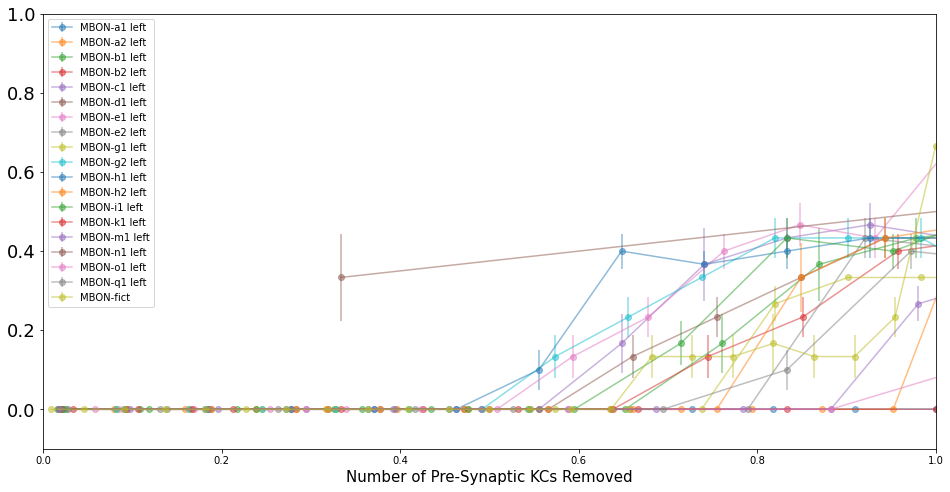

In [82]:
# % OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - TARGETED ABLATION OF TOP KCS

# import data
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/targeted-ablation/all-error-rates2.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v2/3-odors/control/all-error-rates1.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

plot_error_vs_percentKCsRemoved(kc_mbon, error_control, error_over_time)

#### 10 Odors

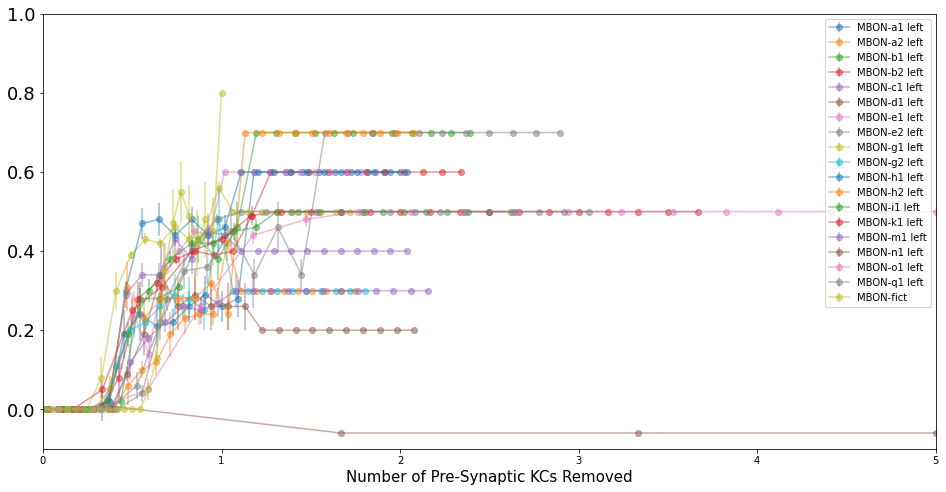

In [139]:
# % OF KCS REMOVED VS. FINAL ERROR RATE MINUS CONTROL ERROR RATE - TARGETED ABLATION OF TOP KCS

# import data
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/targeted-ablation/all-error-rates5.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/control/all-error-rates4.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

plot_error_vs_percentKCsRemoved(kc_mbon, error_control, error_over_time)

### Random Ablation

#### 3 Odors

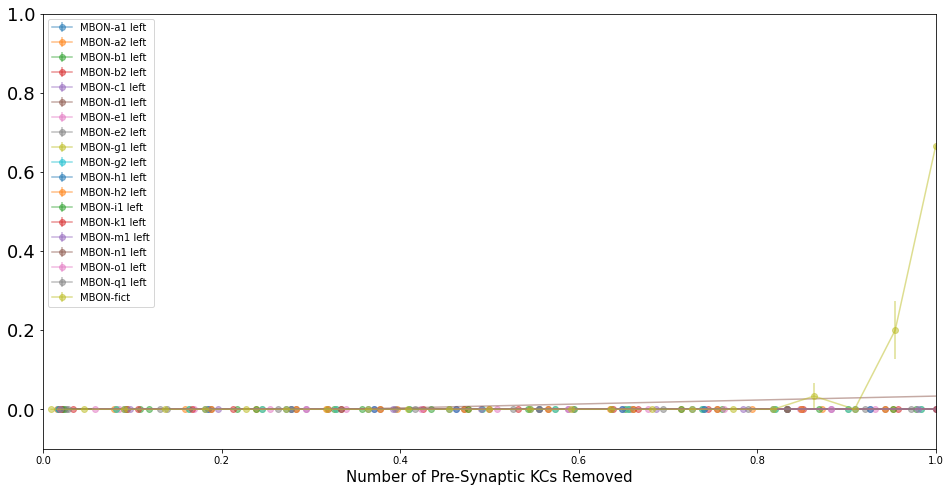

In [84]:
# import data
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/random-ablation/all-error-rates3.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/control/all-error-rates1.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

plot_error_vs_percentKCsRemoved(kc_mbon, error_control, error_over_time)

#### 10 Odors

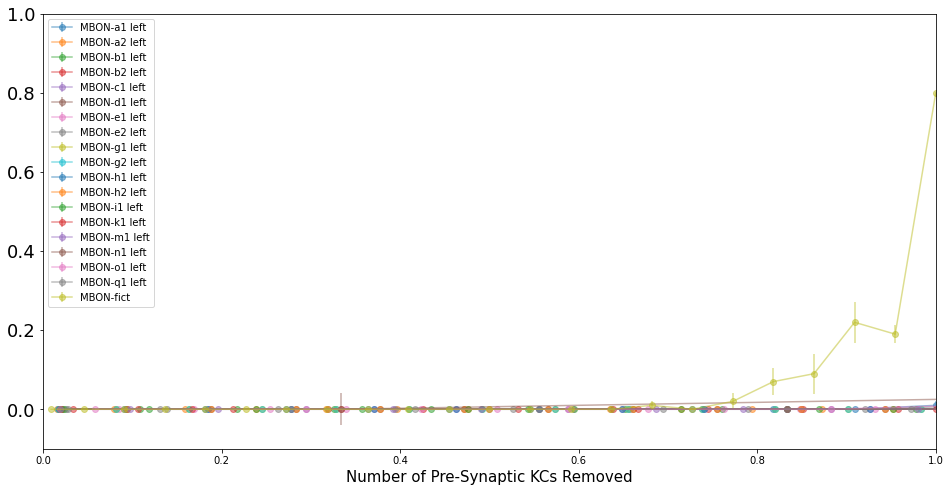

In [91]:
# import data
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/random-ablation/all-error-rates6.pkl', 'rb') as f:
    error_over_time = pickle.load(f) # dimensions: K, R, T, num_mbons
    
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/control/all-error-rates4.pkl', 'rb') as f:
    error_control = pickle.load(f) # dimensions: R, T, num_mbons

plot_error_vs_percentKCsRemoved(kc_mbon, error_control, error_over_time)

## Bar Graph of Type of KCs Ablated

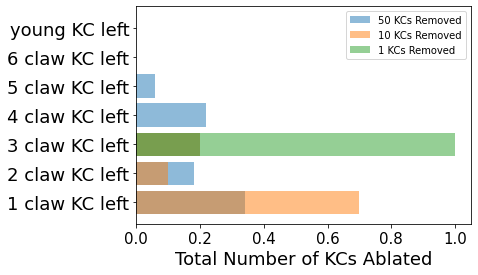

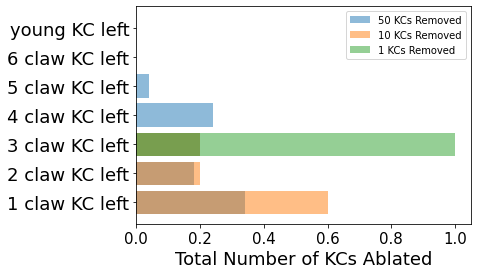

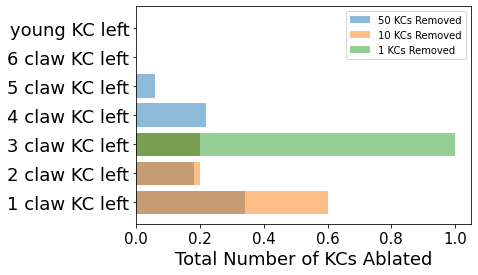

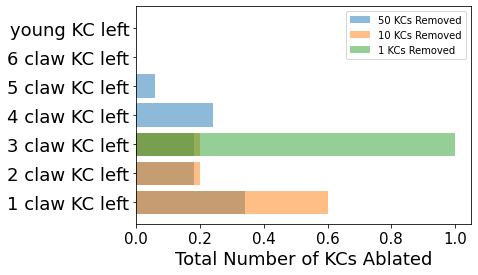

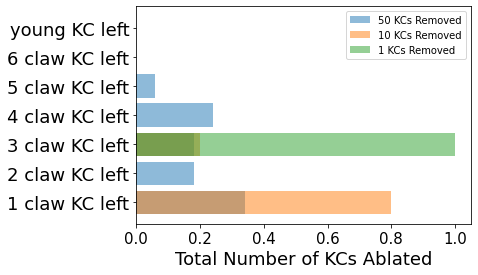

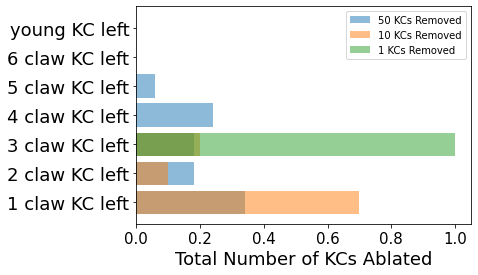

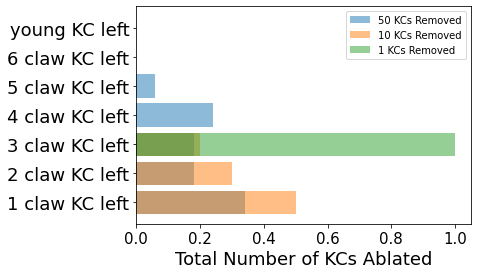

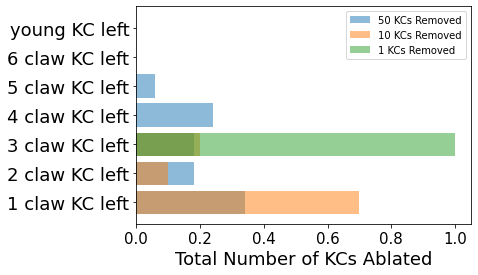

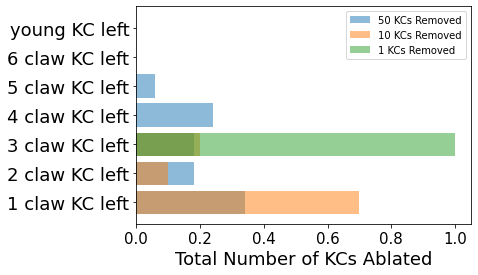

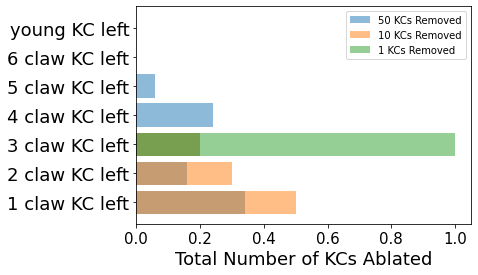

In [10]:
# counts number of occurrences of a string in a 2d list
def countX(lst, x):
    count = 0
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if (lst[i][j] == x):
                count = count + 1
    return count

# BAR GRAPH OF TYPE OF KC REMOVED (5 removed)
names = ['1 claw KC left', '2 claw KC left', '3 claw KC left', '4 claw KC left', '5 claw KC left', '6 claw KC left', 'young KC left']
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/10-odors/targeted-ablation/kcs-removed5.pkl', 'rb') as f:
    kc_names = pickle.load(f)

for j in range(10):
    plt.figure()
    num_real = j # realization to get KC names from

    # nums = [100, 75, 50, 25, 5, 1] # numbers of KCs removed
    # nums_idx = [20, 15, 10, 5, 1, 0] # indicies for each number of KCs removed

    nums = [50, 10, 1] #[50, 30, 20, 10, 5, 1] # numbers of KCs removed
    nums_idx = [10, 2, 0] #[10, 6, 4, 2, 1, 0] # indicies for each number of KCs removed
    rows, cols = (5, 7)
    counts = [] # nums by counts of names of KCs 
    for n in range(len(nums)):
        names_list = kc_names[nums_idx[n]][num_real]
        col = []
        for c in range(cols):
            col.append(names_list.count(names[c]) / float(nums[n]))
        counts.append(col)
#     print(counts)
    
    for i in range(len(nums)):
        label = "{} KCs Removed".format(nums[i])
        if i > 0:
            plt.barh(names, counts[i], label=label, alpha=0.5)
        else:
            plt.barh(names, counts[i], label=label, alpha=0.5)

    plt.xlabel("Total Number of KCs Ablated", fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=18, rotation=0)

    plt.legend(fontsize=10)
    plt.show()
# divide by total number of kcs removed 
# divide by number of each type of KCs

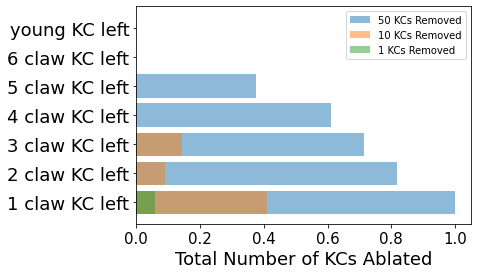

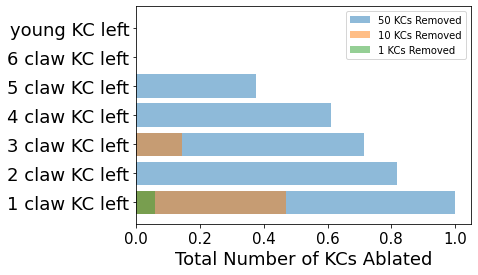

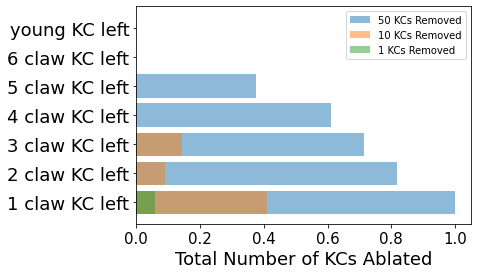

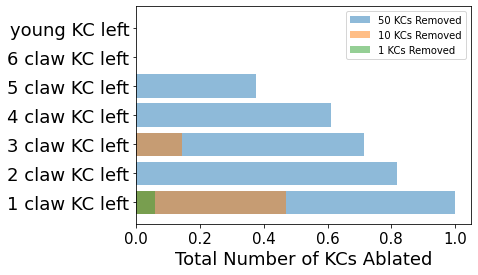

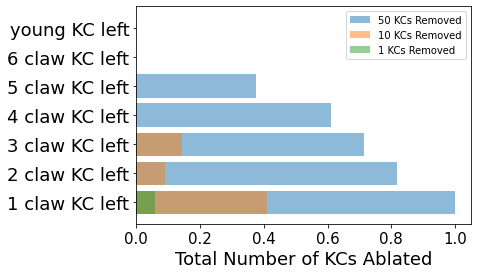

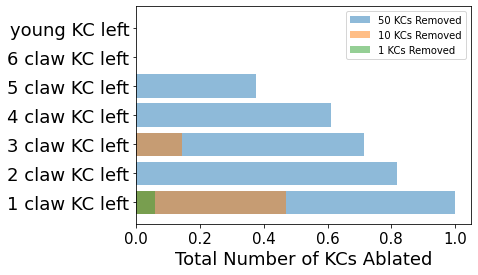

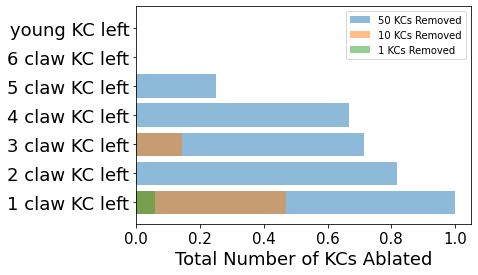

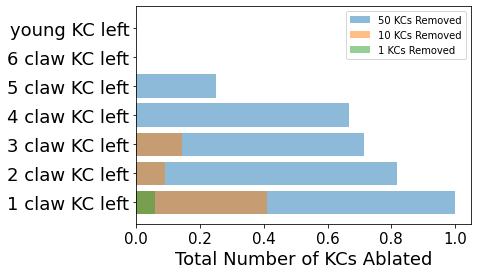

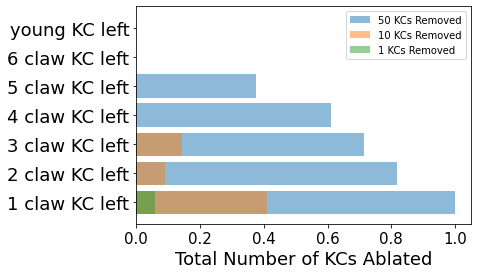

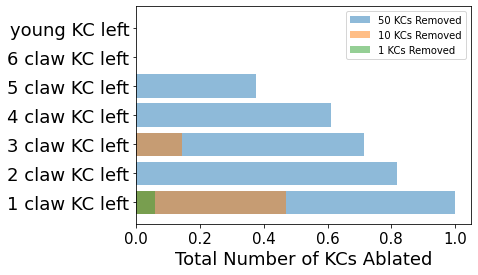

In [8]:
# BAR GRAPH OF TYPE OF KC REMOVED DIVIDED BY THE TOTAL OF EACH TYPE OF KC
names = ['1 claw KC left', '2 claw KC left', '3 claw KC left', '4 claw KC left', '5 claw KC left', '6 claw KC left', 'young KC left']
totals = [17, 11, 14, 18, 8, 5, 37]
with open('C:/Users/Katherine Xie/RiseProject/experiment-data-v3/3-odors/targeted-ablation/kcs-removed2.pkl', 'rb') as f:
    kc_names = pickle.load(f)

for j in range(10):
    plt.figure()
    num_real = j # realization to get KC names from

    # nums = [100, 75, 50, 25, 5, 1] # numbers of KCs removed
    # nums_idx = [20, 15, 10, 5, 1, 0] # indicies for each number of KCs removed

    nums = [50, 10, 1] #[50, 30, 20, 10, 5, 1] # numbers of KCs removed
    nums_idx = [10, 2, 0] #[10, 6, 4, 2, 1, 0] # indicies for each number of KCs removed
    rows, cols = (len(nums), 7)
    counts = [] # nums by counts of names of KCs 
    for n in range(len(nums)):
        names_list = kc_names[nums_idx[n]][num_real]
#         print(names_list)
        col = []
        for c in range(cols):
            col.append(names_list.count(names[c]) / float(totals[c]))
        counts.append(col)
#     print(counts)
    
    for i in range(len(nums)):
        label = "{} KCs Removed".format(nums[i])
        if i > 0:
            plt.barh(names, counts[i], label=label, alpha=0.5)
        else:
            plt.barh(names, counts[i], label=label, alpha=0.5)

    plt.xlabel("Total Number of KCs Ablated", fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=18, rotation=0)

    plt.legend(fontsize=10)
    plt.show()